In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set(style="whitegrid")

In [2]:
def get_df_results(validation_type='large_mol', 
                   model_sel='RF2', 
                   descriptors=["XTB", "Selected", "Custom", "Rdkit-Vbur", "Gasteiger", "BDE", "ENV-2"]):
    """
    Validation type has to be in ['large_mol', 'loo']
    """    
    # get the good column names
    if validation_type == 'large_mol':
        col_model = 'Model'
        col_desc  = 'Descriptor'
        file      = 'df_results.csv'
    elif validation_type == 'loo':
        col_model = 'Model'
        col_desc  = 'Feature'
        file      = 'results_loo.csv'

    # get the files
    runs = os.listdir(f"../results/model_validation/regression/{validation_type}/dioxirane")
    runs = [run for run in runs if 'clean_run' in run]
    columns = runs.copy()
    columns.append(col_model)
    columns.append(col_desc)
    df_results = pd.DataFrame(columns=columns)
    df_results.set_index([col_model, col_desc], inplace=True)
    for run in runs:
        try:
            local_df = pd.read_csv(f"../results/model_validation/regression/{validation_type}/dioxirane/{run}/{file}")
            local_df.rename(columns={'TOP-1': 'TOP1'}, inplace=True)
            for desc in np.unique(local_df[col_desc].values):
                for model in local_df[col_model].unique():
                    if model == model_sel:
                        val = local_df[(local_df[col_model] == model) & (local_df[col_desc] == desc)].TOP1.values[0]
                        if validation_type == 'large_mol':
                            val = val*100/50
                        #print(model, desc, run, val)
                        df_results.loc[(model, desc), run] = val

        except:
            print(f"../results/model_validation/regression/{validation_type}/dioxirane/{run}/{file} in {run}")
            df_results.drop(run, axis=1, inplace=True)
            continue


    df_results.reset_index(inplace=True)
    df_results

    df_res = df_results[df_results[col_model] == model_sel]
    df_res = df_res[df_res[col_desc].isin(descriptors)]
    df_res.set_index([col_desc], inplace=True)
    df_res.drop(col_model, axis=1, inplace=True)
    #print(df_res)   
    return df_res

In [5]:
df_res_bm  = get_df_results(validation_type='large_mol')
df_res_bm.reset_index(inplace=True)
df_res_bm.rename(columns={'Descriptor': 'Descriptors'}, inplace=True)
df_res_loo = get_df_results(validation_type='loo')

df_res_loo.reset_index(inplace=True)
df_res_loo.rename(columns={'Feature': 'Descriptors'}, inplace=True)

df_res_bm.set_index('Descriptors', inplace=True)
df_res_loo.set_index('Descriptors', inplace=True)

df_res_loo_T = df_res_loo.T
df_res_loo_T = df_res_loo_T[['BDE', 'Gasteiger', 'Rdkit-Vbur', 'ENV-2', 'XTB', 'Selected', 'Custom']]
df_res_bm_T  = df_res_bm.T
df_res_bm_T  = df_res_bm_T[['BDE', 'Gasteiger', 'Rdkit-Vbur', 'ENV-2', 'XTB', 'Selected', 'Custom']]


In [6]:
res_bm_T = df_res_bm.T
res_loo_T = df_res_loo.T
res_bm_T['validation_type'] = 'large_mol'
res_loo_T['validation_type'] = 'loo'

df_res = pd.concat([res_bm_T, res_loo_T], axis=0)


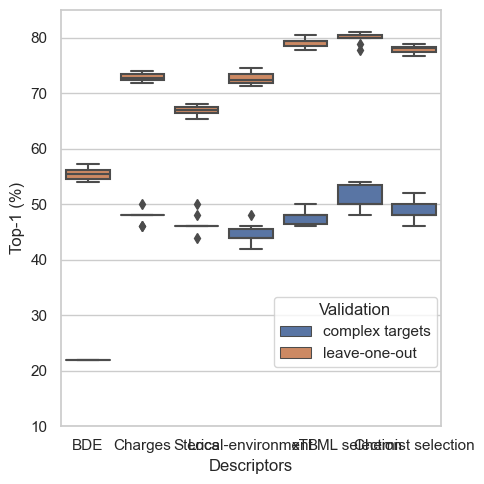

In [7]:
melted = df_res.melt(id_vars='validation_type', value_vars=['BDE', 'Gasteiger', 'Rdkit-Vbur', 'ENV-2', 'XTB', 'Selected', 'Custom'])

melted.rename(columns={'variable': 'Descriptors', 'value': 'Top-1 (%)', 'validation_type': 'Validation'}, inplace=True)
melted.replace({'BDE': 'BDE', 
                'Gasteiger': 'Charges', 
                'Rdkit-Vbur': 'Sterics', 
                'ENV-2': 'Local-environment', 
                'XTB': 'xTB', 
                'Selected': 'ML selection', 
                'Custom': 'Chemist selection',
                'loo': 'leave-one-out',
                'large_mol': 'complex targets'}, inplace=True)
fig, ax = plt.subplots(1,1, figsize=(5, 5))
sns.boxplot(data=melted, dodge=False,
            hue='Validation', y='Top-1 (%)', x='Descriptors', ax=ax)

ax.set_ylim(10,85)
ax.legend(loc=[0.56, 0.142], title='Validation')
fig.tight_layout()
fig.savefig('top1_boxplot_bm_vs_loo_3.png', dpi=600)